Classification Metrics:
Accuracy: 0.5926
Precision: 0.5298
Recall: 0.9302
F1 Score: 0.6751

Confusion Matrix:
[[32 71]
 [ 6 80]]


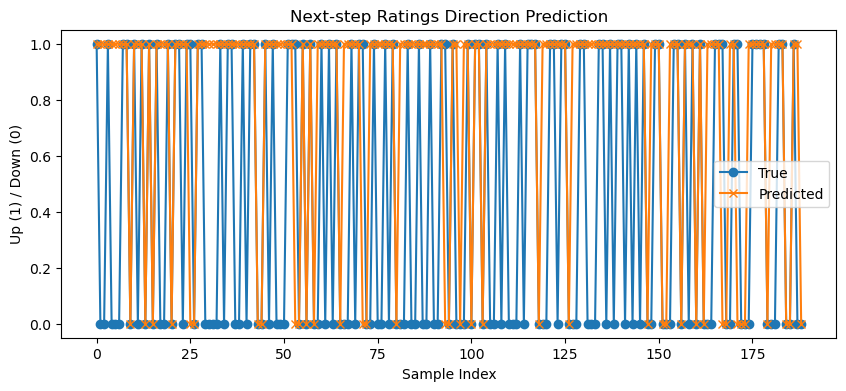

In [1]:
# -----------------------------
# 10b) Time Series / Classification
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Load dataset
# -----------------------------
df = pd.read_csv("./data/processed/amazon_bestsellers_2025_cleaned.csv")

# Clean product_price
df["product_price"] = (
    df["product_price"]
    .astype(str)
    .str.replace(r"[^\d.]", "", regex=True)
    .replace("", np.nan)
    .astype(float)
)

df = df.dropna(subset=["product_price"])

# Sort by rank to simulate temporal sequence
df = df.sort_values("rank").reset_index(drop=True)

# -----------------------------
# 2. Feature engineering: lag & rolling
# -----------------------------
df["ratings_lag1"] = df["product_num_ratings"].shift(1)
df["ratings_lag2"] = df["product_num_ratings"].shift(2)
df["rolling_mean_3"] = df["product_num_ratings"].rolling(3).mean()
df["rolling_std_3"] = df["product_num_ratings"].rolling(3).std()

# Drop rows with NaNs created by lag/rolling
df = df.dropna().reset_index(drop=True)

# -----------------------------
# 3. Create target: next-step direction (up/down)
# -----------------------------
df["target_up"] = (df["product_num_ratings"].shift(-1) > df["product_num_ratings"]).astype(int)
df = df.dropna(subset=["target_up"])  # drop last row with no next step

# -----------------------------
# 4. Features and target
# -----------------------------
features = ["product_price", "ratings_lag1", "ratings_lag2", "rolling_mean_3", "rolling_std_3"]
X = df[features]
y = df["target_up"]

# -----------------------------
# 5. Time-aware train/test split
# -----------------------------
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# -----------------------------
# 6. Build pipeline
# -----------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# -----------------------------
# 7. Evaluation
# -----------------------------
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Classification Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)

# -----------------------------
# 8. Optional: plot predictions vs true
# -----------------------------
plt.figure(figsize=(10,4))
plt.plot(y_test.values, label="True", marker='o')
plt.plot(y_pred, label="Predicted", marker='x')
plt.title("Next-step Ratings Direction Prediction")
plt.xlabel("Sample Index")
plt.ylabel("Up (1) / Down (0)")
plt.legend()
plt.show()